<a href="https://colab.research.google.com/github/nancy280/Smoke-Detection-in-Laproscopic-Surgery/blob/main/Smoke_detection_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smoke Detection in Laproscopic Image






In [ ]:
pip install tabulate


In [ ]:
!pip install PyWavelets

##Import Library

In [ ]:
from PIL import Image
import time
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision.utils import make_grid
import zipfile
import os
import shutil
import torch
from torchvision import datasets, transforms
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import  confusion_matrix


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load dataset

In [ ]:
# define batch size
batch_size = 64

# if uploaded directly to colab
zip_path = '/content/drive/My Drive/ML WORK/small dataset.zip'  # path where the zip is uploaded
extracted_dir = '/content/extracted_dataset_laproscopy'

# extract the zip file
if not os.path.exists(extracted_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir)

# create combined directories for train and test data, with class subfolders
combined_train_dir = '/content/data_combined_train'
combined_test_dir = '/content/data_combined_test'
train_clear_dir = os.path.join(combined_train_dir, 'clear')
train_hazy_dir = os.path.join(combined_train_dir, 'hazy')
test_dir = os.path.join(combined_test_dir, 'test_clip')

# ensure the directories are clean
if os.path.exists(combined_train_dir):
    shutil.rmtree(combined_train_dir)
if os.path.exists(combined_test_dir):
    shutil.rmtree(combined_test_dir)

# create the necessary directories for ImageFolder structure
os.makedirs(train_clear_dir)
os.makedirs(train_hazy_dir)
os.makedirs(test_dir)

# dynamically find all subfolders that contain 'clear', 'hazy', and 'test_clip'
for folder_name in os.listdir(extracted_dir):
    folder_path = os.path.join(extracted_dir, folder_name)
    if os.path.isdir(folder_path):  # only proceed if it's a directory
        clear_path = os.path.join(folder_path, 'clear')
        hazy_path = os.path.join(folder_path, 'hazy')
        test_clip_path = os.path.join(folder_path, 'test_clip')

        # copy clear images into the clear train directory if 'clear' folder exists
        if os.path.exists(clear_path):
            for file_name in os.listdir(clear_path):
                full_file_name = os.path.join(clear_path, file_name)
                if os.path.isfile(full_file_name):
                    shutil.copy(full_file_name, train_clear_dir)

        # copy hazy images into the hazy train directory if 'hazy' folder exists
        if os.path.exists(hazy_path):
            for file_name in os.listdir(hazy_path):
                full_file_name = os.path.join(hazy_path, file_name)
                if os.path.isfile(full_file_name):
                    shutil.copy(full_file_name, train_hazy_dir)

        # copy test images into the combined testing directory if 'test_clip' folder exists
        if os.path.exists(test_clip_path):
            for file_name in os.listdir(test_clip_path):
                full_file_name = os.path.join(test_clip_path, file_name)
                if os.path.isfile(full_file_name):
                    shutil.copy(full_file_name, test_dir)



## Normalization of the Laproscopic Images

In [ ]:
# define transformations
transforms_train = transforms.Compose([
    transforms.Resize(225),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

transforms_test = transforms.Compose([
    transforms.Resize(225),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# step 5: create datasets and dataloaders
train_data = datasets.ImageFolder(root=combined_train_dir, transform=transforms_train)

test_data = datasets.ImageFolder(root=combined_test_dir, transform=transforms_test)

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# step 6: verify data loading
print(f'Number of training images: {len(train_data)}')
print(f'Number of testing images: {len(test_data)}')

# check class names (should be ['clear', 'hazy'] if directory structure is correct)
print(f'Class names: {train_data.classes}')


Number of training images: 4800
Number of testing images: 400
Class names: ['clear', 'hazy']


Original Images (Before Normalization):


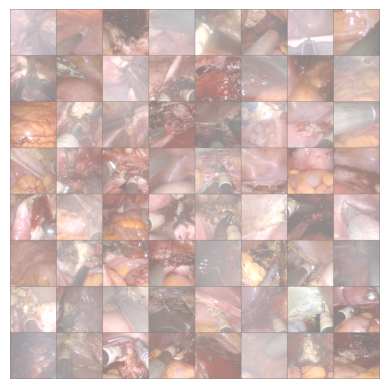

Normalized Images:


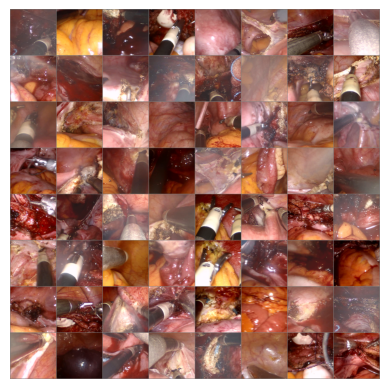

In [ ]:
# Step 1: Load dataset with and without normalization
train_data_original = datasets.ImageFolder(root=combined_train_dir, transform=transforms.Compose([
    transforms.Resize(225),
    transforms.CenterCrop(224),
    transforms.ToTensor()  # Only convert to tensor, no normalization
]))

train_data_normalized = datasets.ImageFolder(root=combined_train_dir, transform=transforms_train)

train_data_loader_original = torch.utils.data.DataLoader(train_data_original, batch_size=batch_size, shuffle=True)
train_data_loader_normalized = torch.utils.data.DataLoader(train_data_normalized, batch_size=batch_size, shuffle=True)

# Get a batch of images from each loader
images_original, _ = next(iter(train_data_loader_original))
images_normalized, _ = next(iter(train_data_loader_normalized))

# Display function for visualizing images
def image_display(image_tensor, title=None):
    image_tensor = image_tensor / 2 + 0.5  # De-normalize if normalized to [-1, 1]
    numpy_image = image_tensor.numpy()
    transposed_numpy_image = np.transpose(numpy_image, (1, 2, 0))
    plt.imshow(transposed_numpy_image)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

# Show the original images
print("Original Images (Before Normalization):")
image_display(make_grid(images_original))

# Show the normalized images
print("Normalized Images:")
image_display(make_grid(images_normalized))

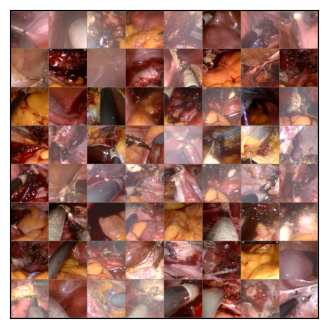

In [ ]:
images, labels = next(iter(train_data_loader))

def image_display(image, title=None):
    image = image/2 + 0.5
    numpy_image = image.numpy()
    transposed_numpy_image = np.transpose(numpy_image, (1, 2, 0))
    plt.figure(figsize=(20, 4))
    plt.imshow(transposed_numpy_image)
    plt.yticks([])
    plt.xticks([])
    if title:
        plt.title(title)
    plt.show

image_display(torchvision.utils.make_grid(images))

## Functions for extracting Features from images

In [ ]:
import cv2
import pywt
from skimage.color import rgb2hsv
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# Function to calculate normalized RGB
def normalized_rgb(image):
    r, g, b = cv2.split(image)
    sum_rgb = r + g + b + 1e-6  # avoid division by zero
    r_norm = r / sum_rgb
    g_norm = g / sum_rgb
    b_norm = b / sum_rgb
    return np.mean(r_norm), np.mean(g_norm), np.mean(b_norm)

# Function to calculate wavelet energy
def wavelet_energy(image):
    coeffs = pywt.wavedec2(image, 'haar', level=1)
    cA, (cH, cV, cD) = coeffs
    energy_H = np.sum(np.square(cH))
    energy_V = np.sum(np.square(cV))
    energy_D = np.sum(np.square(cD))
    return energy_H, energy_V, energy_D


# Function to calculate HSV color space feature (saturation range)
def hsv_saturation_feature(image):
    hsv_img = rgb2hsv(image)
    s_channel = hsv_img[:, :, 1]
    s_range_count = np.sum((s_channel >= 0.4) & (s_channel <= 0.6))
    return s_range_count

# Function to calculate optical flow feature (Horn-Schunck algorithm)
def optical_flow_feature(prev_frame, next_frame):
    hsv_prev = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    hsv_next = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(hsv_prev, hsv_next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    return np.sum(mag > 0.5)  # Example threshold for significant motion

def fog_area(image):
    # convert the image to hsv color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # apply gaussian blur to smooth the image, helping with fog detection accuracy
    blurred = cv2.GaussianBlur(hsv, (7, 7), 0)
    # refined hsv range to detect fog more accurately
    lower_fog = (0, 0, 150)  # lower bound of fog in HSV
    upper_fog = (180, 60, 255)  # upper bound of fog in HSV
    # create a mask to capture fog-like areas
    mask = cv2.inRange(blurred, lower_fog, upper_fog)
    # calculate the number of fog area pixels and normalize by total pixels
    fog_area_pixels = np.sum(mask > 0)
    total_pixels = image.shape[0] * image.shape[1]
    fog_coverage_ratio = fog_area_pixels / total_pixels  # percentage of area covered by fog

    return fog_coverage_ratio * 100  # return as a percentage


## Creating array of the extracted features

In [ ]:
import numpy as np
import cv2
import pywt
from skimage.color import rgb2hsv

# Placeholder for loading your data
# train_data_loader should yield images and corresponding labels

def extract_features_and_labels(data_loader):
    features = []
    labels = []

    for i, (inputs, batch_labels) in enumerate(data_loader):
        for j in range(inputs.size(0)):  # Loop through each image in the batch
            image = np.array(inputs[j].permute(1, 2, 0))  # Convert from tensor to numpy array

            # Compute each feature
            norm_rgb_features = normalized_rgb(image)
            wavelet_features = wavelet_energy(image)
            hsv_feature = hsv_saturation_feature(image)
            # fog_area_feature = fog_area(image)

            # Combine features into a single array
            feature_vector = np.array([
                *norm_rgb_features,
                *wavelet_features,
                hsv_feature,
                # fog_area_feature,
            ])
            features.append(feature_vector)

        labels.extend(batch_labels.tolist())  # Convert batch_labels to list and add all at once

    return np.array(features), np.array(labels)

train_features, train_labels = extract_features_and_labels(train_data_loader)


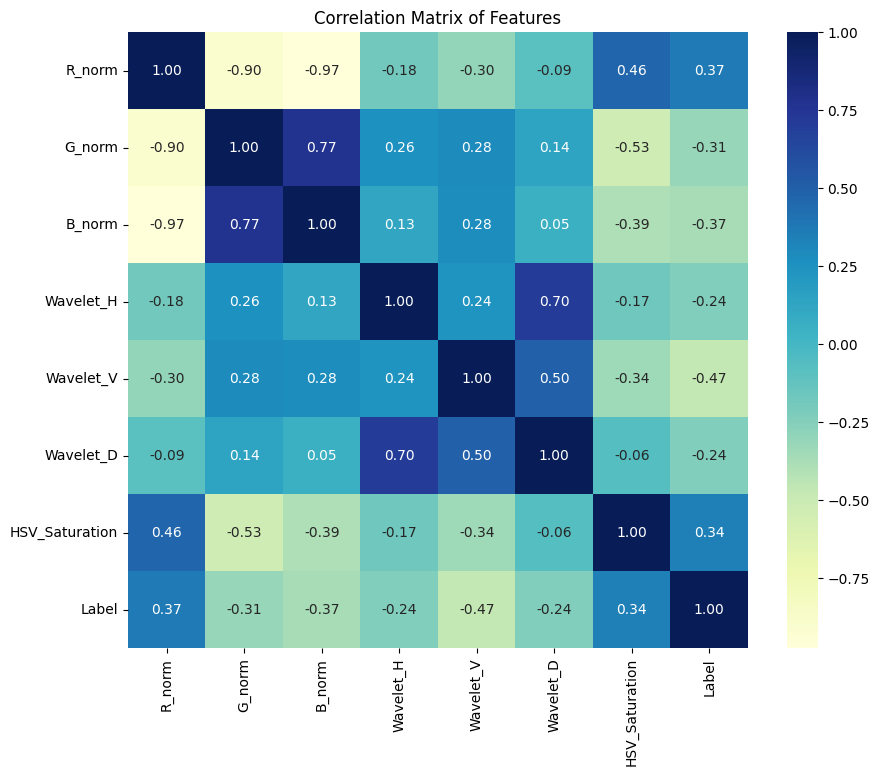

In [ ]:
import seaborn as sns
import pandas as pd

# Create a Pandas DataFrame
feature_names = ['R_norm', 'G_norm', 'B_norm', 'Wavelet_H', 'Wavelet_V', 'Wavelet_D', 'HSV_Saturation']
df = pd.DataFrame(train_features, columns=feature_names)
df['Label'] = train_labels

# Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

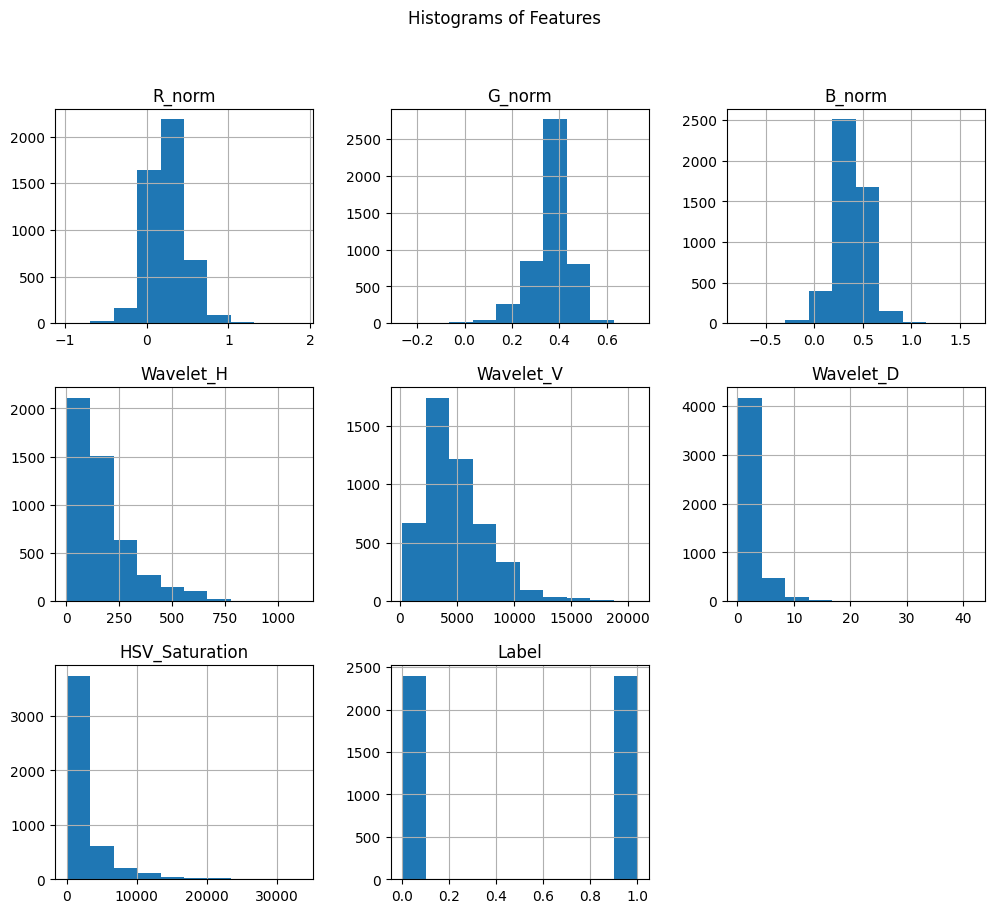

In [ ]:
# Histograms
df.hist(figsize=(12, 10))
plt.suptitle('Histograms of Features')
plt.show()


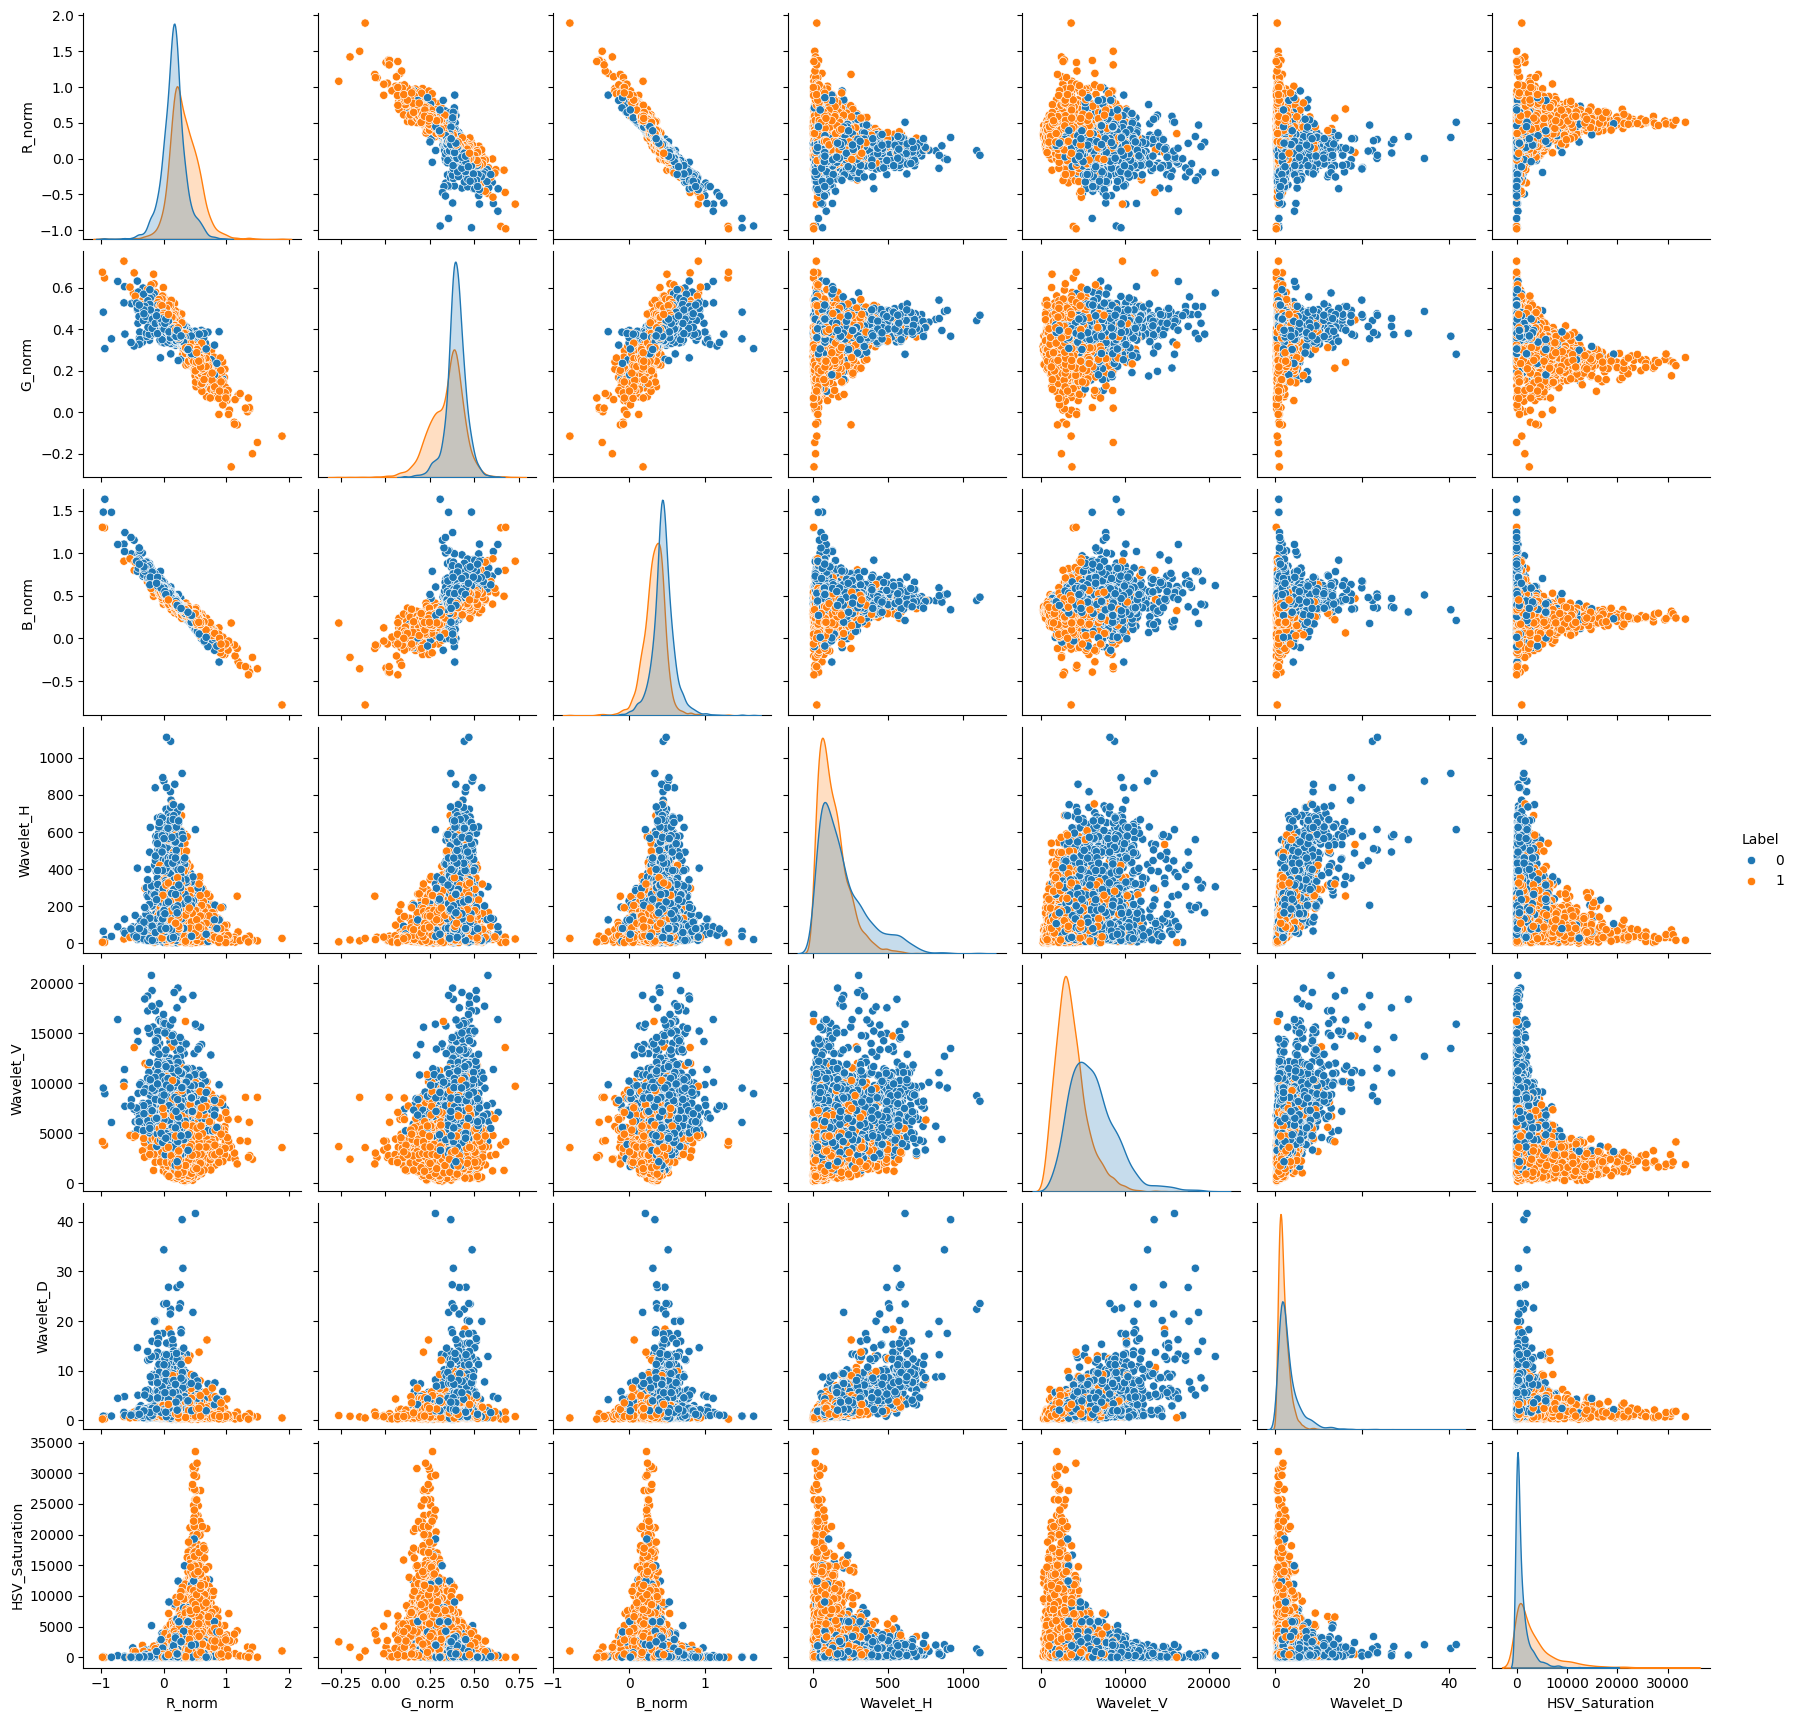

In [ ]:
sns.pairplot(df, hue='Label', diag_kind='kde')
plt.show()

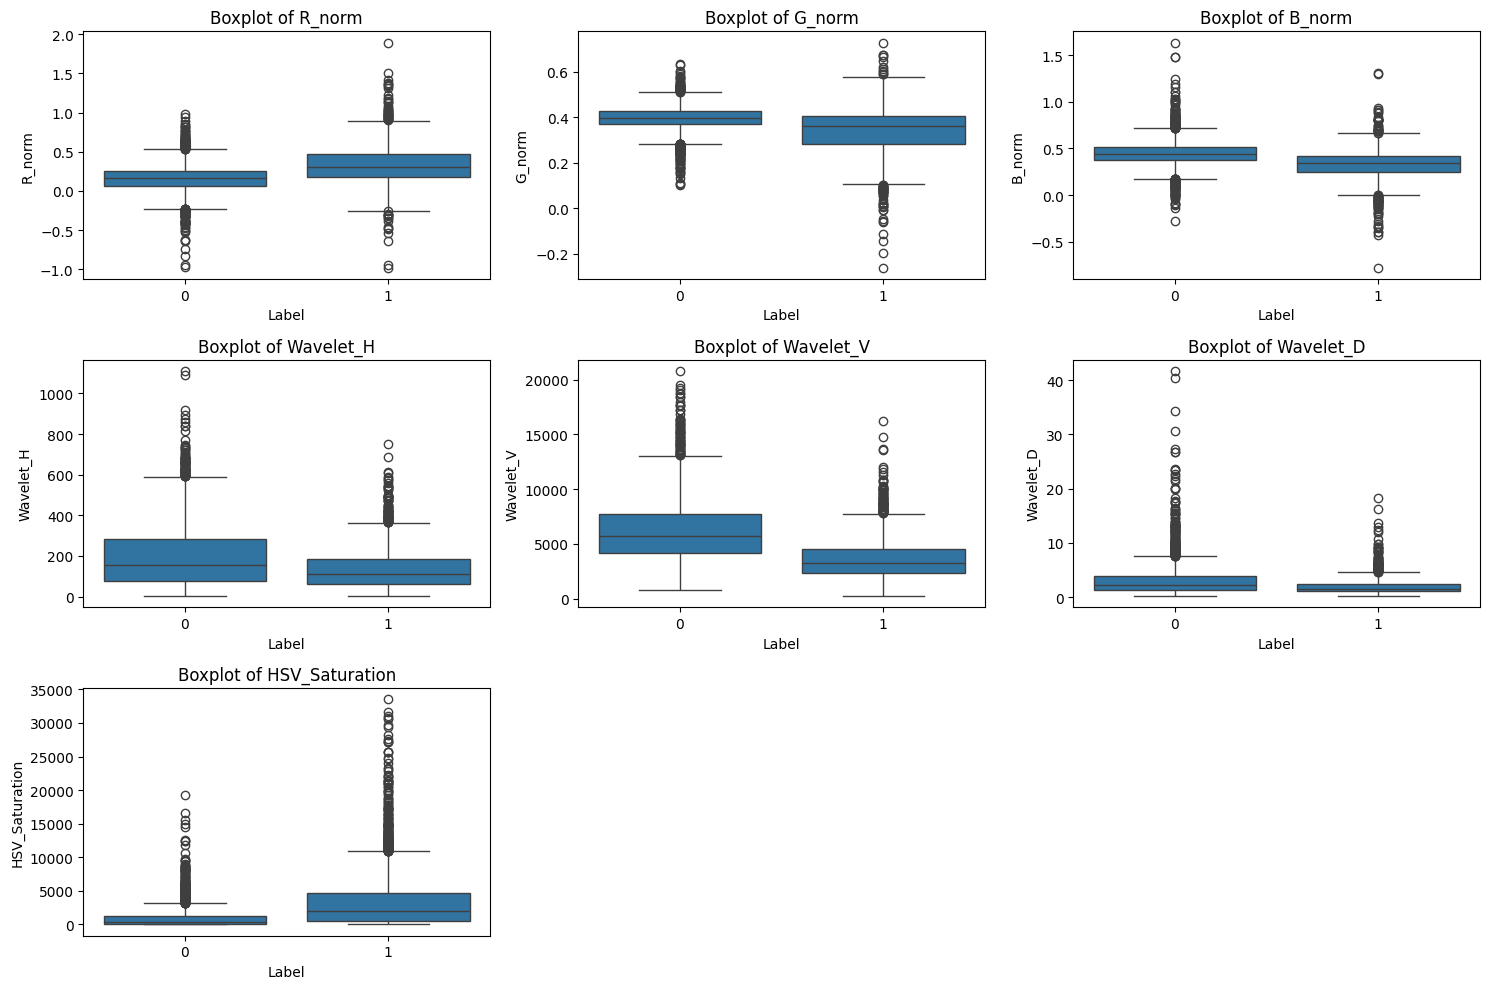

In [ ]:
# Boxplots for each feature grouped by label
plt.figure(figsize=(15, 10))
for i, feature in enumerate(feature_names):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='Label', y=feature, data=df)
    plt.title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

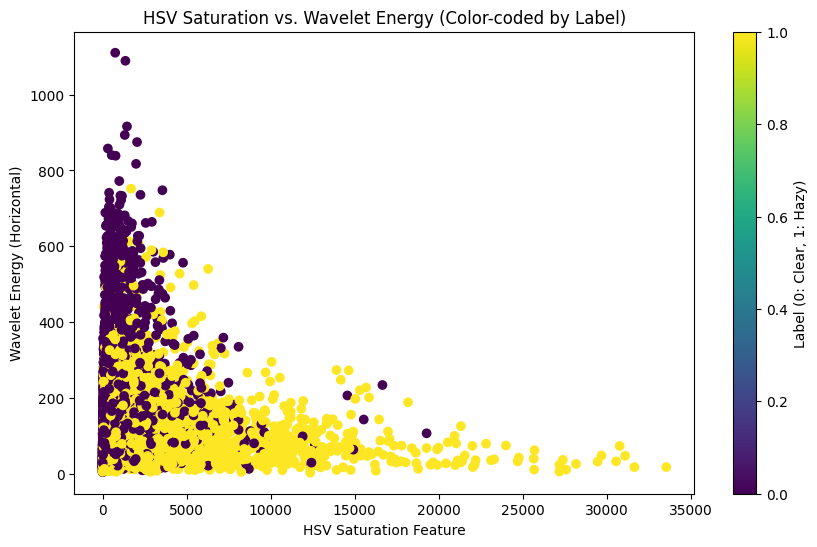

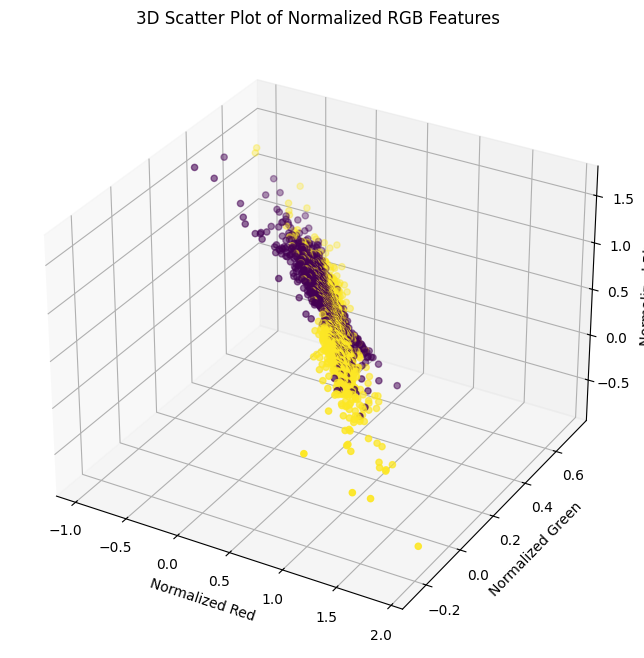

In [ ]:
# Example of a weird plot: Scatter plot of HSV Saturation vs. Wavelet Energy
plt.figure(figsize=(10, 6))
plt.scatter(train_features[:, 6], train_features[:, 3], c=train_labels, cmap='viridis')
plt.xlabel('HSV Saturation Feature')
plt.ylabel('Wavelet Energy (Horizontal)')
plt.title('HSV Saturation vs. Wavelet Energy (Color-coded by Label)')
plt.colorbar(label='Label (0: Clear, 1: Hazy)')
plt.show()

# Example of a 3D scatter plot (if you have more features)
# You can use mpl_toolkits.mplot3d for 3D plots
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_features[:, 0], train_features[:, 1], train_features[:, 2], c=train_labels, cmap='viridis')
ax.set_xlabel('Normalized Red')
ax.set_ylabel('Normalized Green')
ax.set_zlabel('Normalized Blue')
ax.set_title('3D Scatter Plot of Normalized RGB Features')
plt.show()




## Building model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate


def create_optimized_smoke_detection_model(image_shape=(224, 224, 3), additional_features_shape=(7,)):
    # Image input (RGB + HSV + Wavelet + Optical Flow, etc.)
    image_input = Input(shape=image_shape, name='image_input')

    # Convolutional layers for feature extraction
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(image_input)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
    x = Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)

    # Additional features input (8 features)
    additional_features_input = Input(shape=additional_features_shape, name='additional_features_input')

    # Concatenate image features with additional features
    combined = Concatenate()([x, additional_features_input])

    # Fully connected layers
    x = Dense(512, activation='relu')(combined)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer
    output = Dense(1, activation='sigmoid')(x)

    # Define the model with image and additional features inputs
    model = Model(inputs=[image_input, additional_features_input], outputs=output)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy' ,
                  metrics=['accuracy'])

    return model

# Example usage:
image_shape = (224, 224, 3)  # Change according to your input image size
additional_features_shape = (7,)  # Number of features (e.g., RGB + wavelet + fog area)

# Build the model
model = create_optimized_smoke_detection_model(image_shape, additional_features_shape)

# Print model summary
model.summary()


Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 222, 222, 32)   │            896 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 220, 220, 32)   │          9,248 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 110, 110, 32)   │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 108, 108, 64)   │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 106, 106, 64)   │         36,928 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 53, 53, 64)     │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 51, 51, 128)    │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 49, 49, 128)    │        147,584 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 24, 24, 128)    │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 22, 22, 256)    │        295,168 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 20, 20, 256)    │        590,080 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 10, 10, 256)    │              0 │ conv2d_15[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 25600)          │              0 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ additional_features_input │ (None, 7)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 25607)          │              0 │ flatten_1[0][0],       │
│ (Concatenate)             │                        │                │ additional_features_i… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)     

 Total params: 14,415,137 (54.99 MB)

 Trainable params: 14,415,137 (54.99 MB)

 Non-trainable params: 0 (0.00 B)

## Loading the data for the proposed CNN model

In [ ]:
# Load the image data and assign corresponding features from `train_features`
images = []
features = []
labels = []

# Iterate through the DataLoader and extract images, labels, and corresponding features in batches
for i, (inputs, batch_labels) in enumerate(train_data_loader):
    # Convert batch of images to numpy and permute dimensions for TensorFlow compatibility
    images.append(inputs.permute(0, 2, 3, 1).numpy())  # Change from (batch, channels, height, width) to (batch, height, width, channels)

    # Select corresponding feature vectors for this batch
    batch_start_idx = i * train_data_loader.batch_size
    batch_end_idx = batch_start_idx + inputs.size(0)
    features.append(train_features[batch_start_idx:batch_end_idx])  # Select corresponding features for the batch

    # Append labels for the batch
    labels.extend(batch_labels.tolist())

# Convert list of batches to a single numpy array for images, features, and labels
images = np.concatenate(images, axis=0)
features = np.concatenate(features, axis=0)
labels = np.array(labels)

# Split the data into training and validation sets
X_train_images, X_val_images, X_train_features, X_val_features, y_train, y_val = train_test_split(
    images, features, labels, test_size=0.2, random_state=42
)




## Training the model

In [ ]:
# Train the model (assuming TensorFlow is used)
model.fit(
    [X_train_images, X_train_features],  # Input to the model: Image data + Extracted Features
    y_train,  # Labels for the data
    batch_size=32,
    epochs=10,
    validation_data=([X_val_images, X_val_features], y_val),
    verbose=0 # Validation set
)

## Evaluating the proposed model

In [ ]:

# Evaluate the model on the validation set
_, validation_accuracy_of_model_ = model.evaluate([X_val_images, X_val_features], y_val, verbose=0)

# Print the accuracy as a percentage
print(f"Validation Accuracy: {validation_accuracy_of_model_ * 100:.2f}%")

Validation Accuracy: 91.49%


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_val_images, y_val_features)
ProposedCnnModel_report=classification_report(y_val_images, y_val_features,output_dict=True)
print(classification_report(y_val_images, y_val_features))
# Print the accuracy as a percentage with exactly two decimal places
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.92      1.00      0.96        11

    accuracy                           0.92        13
   macro avg       0.96      0.75      0.81        13
weighted avg       0.93      0.92      0.91        13

Overall Accuracy: 92.31%


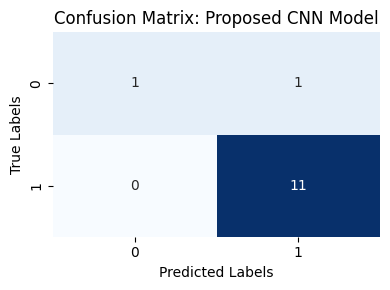

In [ ]:
conf_matrix = confusion_matrix(y_val_images, y_val_features)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.unique(y_val_images), yticklabels=np.unique(y_val_images))
plt.title('Confusion Matrix: Proposed CNN Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

#Comparing with other model



## CNN wth Tanh activation with learning rate 0.001

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

# Assuming you have train_features and train_labels from your previous code

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# Define a more complex feedforward neural network with more layers and techniques
model = Sequential()
model.add(Dense(256, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())  # Batch normalization for stability
model.add(Dropout(0.4))  # Reduced dropout slightly to retain more information

model.add(Dense(128, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Further reduced dropout rate in deeper layers

model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.3))

model.add(Dense(16, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

# Compile the model with an optimizer, loss function, and metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
CnnWithTanh=model
# Print model summary
model.summary()
# Train the model with early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
CnnWithTanh.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])


# Evaluate the model
y_pred = (CnnWithTanh.predict(X_val) > 0.5).astype(int)
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
CnnWithTanh_report=classification_report(y_val, y_pred,output_dict=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 256)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,617 (186.00 KB)

 Trainable params: 46,721 (182.50 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6411 - loss: 0.6996 - val_accuracy: 0.6906 - val_loss: 0.6994
Epoch 2/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6983 - loss: 0.6130 - val_accuracy: 0.6885 - val_loss: 0.6348
Epoch 3/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6870 - loss: 0.6243 - val_accuracy: 0.6812 - val_loss: 0.6240
Epoch 4/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7185 - loss: 0.5800 - val_accuracy: 0.6833 - val_loss: 0.6256
Epoch 5/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6936 - loss: 0.6029 - val_accuracy: 0.6812 - val_loss: 0.6449
Epoch 6/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7025 - loss: 0.5940 - val_accuracy: 0.6865 - val_loss: 0.6393
Epoch 7/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6827 - loss: 0.6069 - val_accuracy: 0.6812 - val_loss: 0.6179
Epoch 8/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7101 - loss: 0.5811 - val_acc

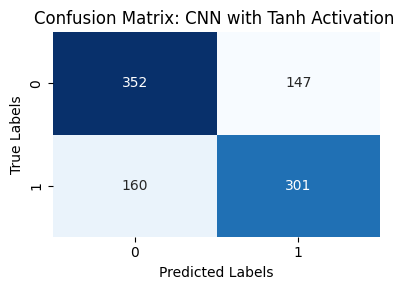

In [ ]:
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.unique(y_val), yticklabels=np.unique(y_pred))
plt.title('Confusion Matrix: CNN with Tanh Activation ')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

## CNN with relu activation and learning rate 0.0005

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# Define a deeper and more complex feedforward neural network
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())  # Batch normalization for stability
model.add(Dropout(0.4))  # Reduced dropout slightly to retain more information

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Further reduced dropout rate in deeper layers

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification

# Compile the model with a more optimized learning rate for adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
CnnWithRelu=model
# Print model summary
model.summary()
# Train the model with early stopping, allowing for a larger patience value
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = CnnWithRelu.fit(X_train, y_train,
                    epochs=2000,
                    batch_size=64,  # Increased batch size for stability
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Evaluate the model
y_pred = (CnnWithRelu.predict(X_val) > 0.5).astype(int)
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_val, y_pred))
CnnWithRelu_report=classification_report(y_val, y_pred,output_dict=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                     │ (None, 256)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,617 (186.00 KB)

 Trainable params: 46,721 (182.50 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/2000
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5690 - loss: 0.9132 - val_accuracy: 0.7260 - val_loss: 0.6514
Epoch 2/2000
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6678 - loss: 0.6510 - val_accuracy: 0.7365 - val_loss: 0.5479
Epoch 3/2000
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6952 - loss: 0.5943 - val_accuracy: 0.7323 - val_loss: 0.5461
Epoch 4/2000
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6901 - loss: 0.6029 - val_accuracy: 0.7281 - val_loss: 0.5510
Epoch 5/2000
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7240 - loss: 0.5678 - val_accuracy: 0.7323 - val_loss: 0.5448
Epoch 6/2000
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7145 - loss: 0.5771 - val_accuracy: 0.7312 - val_loss: 0.5439
Epoch 7/2000
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7258 - loss: 0.5553 - val_accuracy: 0.7250 - val_loss: 0.5467
Epoch 8/2000
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7307 - loss: 0.5467 - val_accuracy: 0

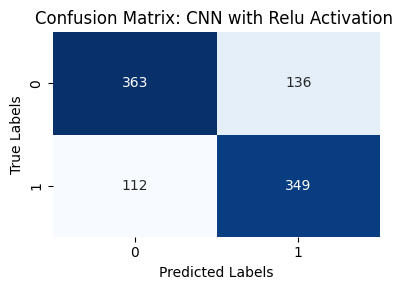

In [ ]:
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.unique(y_val), yticklabels=np.unique(y_pred))
plt.title('Confusion Matrix: CNN with Relu Activation ')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

## Random forest

In [ ]:
# 1. Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_val)
rf_accuracy = accuracy_score(y_val, rf_y_pred)
print("Random Forest Accuracy:", rf_accuracy)
print(rf_model)
print(classification_report(y_val, rf_y_pred))
print("Accuracy:", accuracy_score(y_val, rf_y_pred))
rf_Model_report=classification_report(y_val, rf_y_pred,output_dict=True)

Random Forest Accuracy: 0.7979166666666667
RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200)
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       499
           1       0.80      0.77      0.79       461

    accuracy                           0.80       960
   macro avg       0.80      0.80      0.80       960
weighted avg       0.80      0.80      0.80       960

Accuracy: 0.7979166666666667


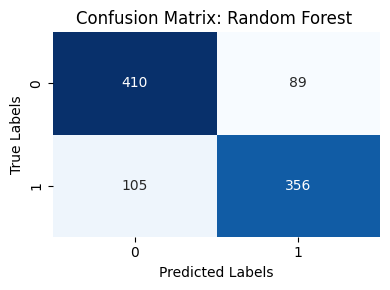

In [ ]:
conf_matrix = confusion_matrix(y_val, rf_y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.unique(y_val), yticklabels=np.unique(rf_y_pred))
plt.title('Confusion Matrix: Random Forest ')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

## Gradient boosting

In [ ]:
# 2. Gradient Boosting (XGBoost)
xgb_model = XGBClassifier(learning_rate=0.05, n_estimators=300, max_depth=5, subsample=0.8, colsample_bytree=0.8)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_val)
xgb_accuracy = accuracy_score(y_val, xgb_y_pred)
print("XGBoost Accuracy:", xgb_accuracy)
print(xgb_model)
print(classification_report(y_val, xgb_y_pred))
print("Accuracy:", accuracy_score(y_val, xgb_y_pred))
xgb_Model_report=classification_report(y_val, xgb_y_pred,output_dict=True)

XGBoost Accuracy: 0.8020833333333334
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       499
           1       0.80      0.78      0.79       461

    accuracy                           0.80   

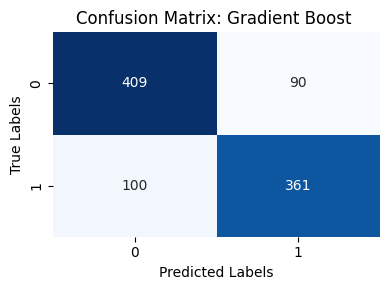

In [ ]:
conf_matrix = confusion_matrix(y_val, xgb_y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.unique(y_val), yticklabels=np.unique(xgb_y_pred))
plt.title('Confusion Matrix: Gradient Boost ')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

## SVM

In [ ]:
# 3. Support Vector Machine (SVM)
svm_model = SVC(kernel='rbf', C=1, gamma='scale')  # You can experiment with different kernels and parameters
svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_val)
svm_accuracy = accuracy_score(y_val, svm_y_pred)
print("SVM Accuracy:", svm_accuracy)
print(svm_model)
print(classification_report(y_val, svm_y_pred))
print("Accuracy:", accuracy_score(y_val, svm_y_pred))
svm_Model_report=classification_report(y_val, svm_y_pred,output_dict=True)

SVM Accuracy: 0.7479166666666667
SVC(C=1)
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       499
           1       0.74      0.72      0.73       461

    accuracy                           0.75       960
   macro avg       0.75      0.75      0.75       960
weighted avg       0.75      0.75      0.75       960

Accuracy: 0.7479166666666667


In [ ]:
from tabulate import tabulate

# define the data for the models and their respective metrics
data = {
    "Model": [
        "Proposed CNN",
        "CNN with Tanh",
        "CNN with ReLU",
        "Random Forest",
        "XGBoost",
        "SVM"
    ],
    "Precision": [0.93, 0.68, 0.74, 0.80, 0.80, 0.75],
    "Recall": [0.92, 0.68, 0.74, 0.80, 0.80, 0.75],
    "F1-Score": [0.91, 0.68, 0.74, 0.80, 0.80, 0.75],
    "Accuracy": [0.92, 0.68, 0.74, 0.80, 0.80, 0.75]
}

# create a pandas dataframe
df = pd.DataFrame(data)

print(tabulate(df, headers="keys", tablefmt="fancy_grid", showindex=False))



╒═══════════════╤═════════════╤══════════╤════════════╤════════════╕
│ Model         │   Precision │   Recall │   F1-Score │   Accuracy │
╞═══════════════╪═════════════╪══════════╪════════════╪════════════╡
│ Proposed CNN  │        0.93 │     0.92 │       0.91 │       0.92 │
├───────────────┼─────────────┼──────────┼────────────┼────────────┤
│ CNN with Tanh │        0.68 │     0.68 │       0.68 │       0.68 │
├───────────────┼─────────────┼──────────┼────────────┼────────────┤
│ CNN with ReLU │        0.74 │     0.74 │       0.74 │       0.74 │
├───────────────┼─────────────┼──────────┼────────────┼────────────┤
│ Random Forest │        0.8  │     0.8  │       0.8  │       0.8  │
├───────────────┼─────────────┼──────────┼────────────┼────────────┤
│ XGBoost       │        0.8  │     0.8  │       0.8  │       0.8  │
├───────────────┼─────────────┼──────────┼────────────┼────────────┤
│ SVM           │        0.75 │     0.75 │       0.75 │       0.75 │
╘═══════════════╧═════════════╧═══

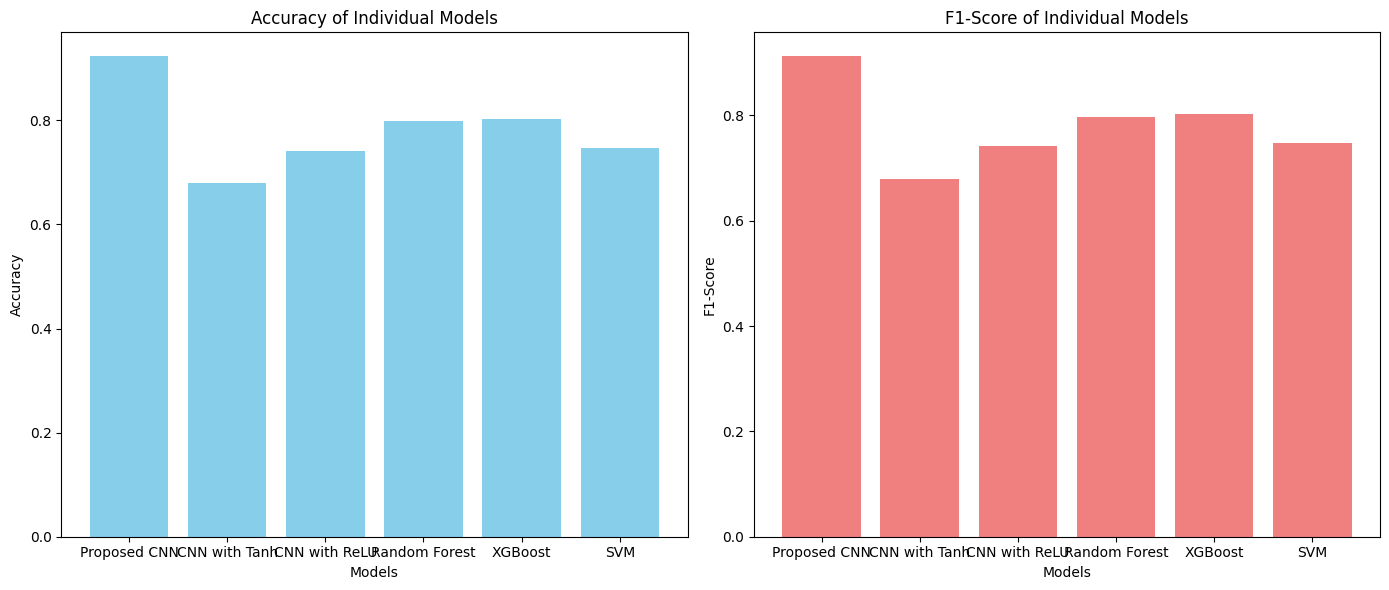

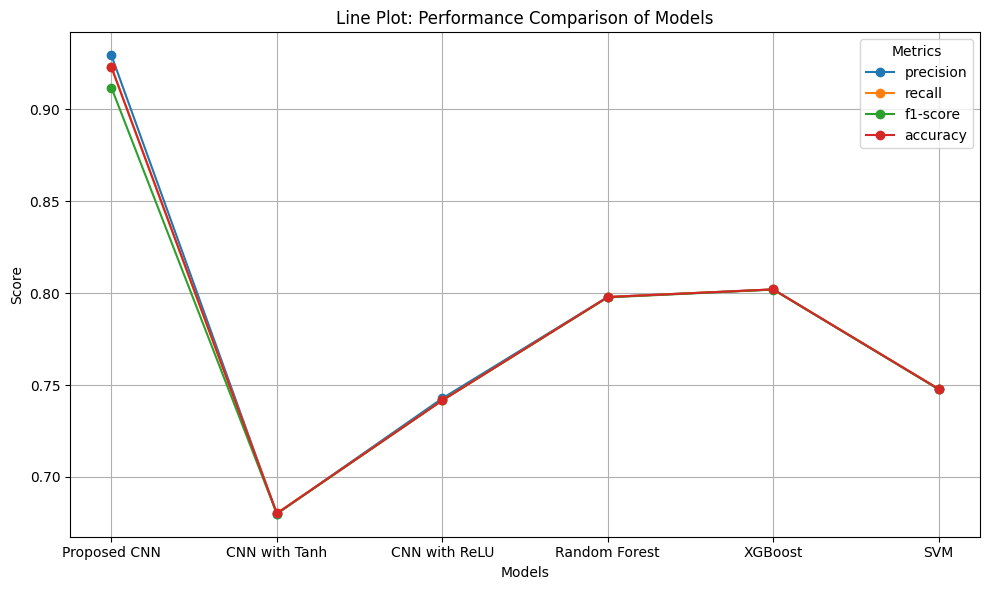

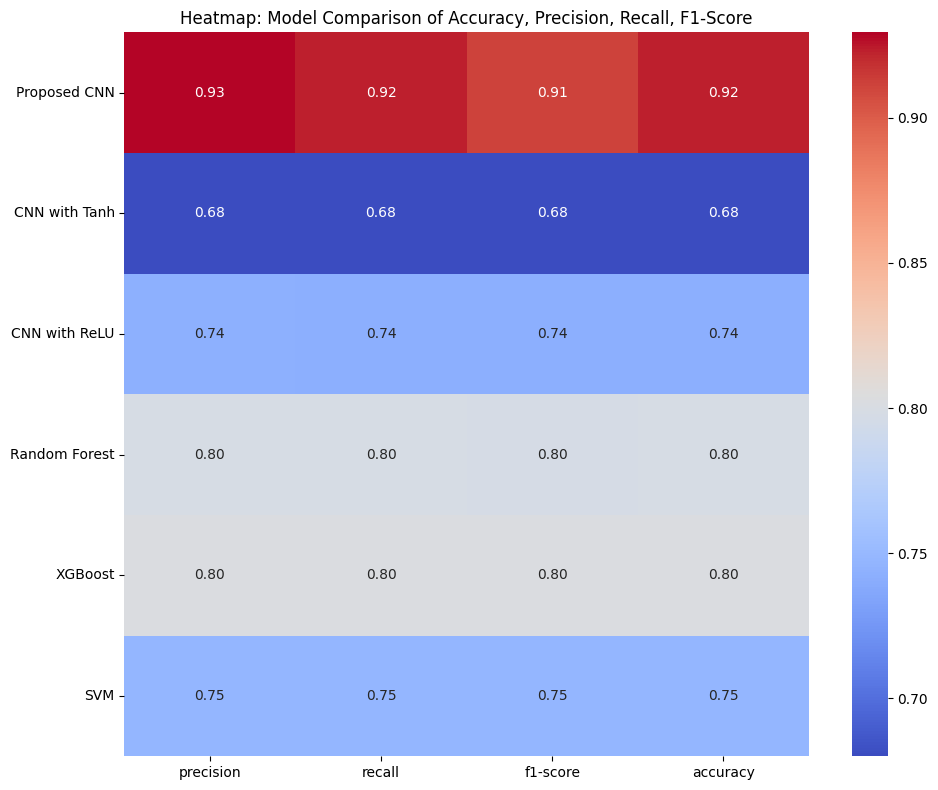

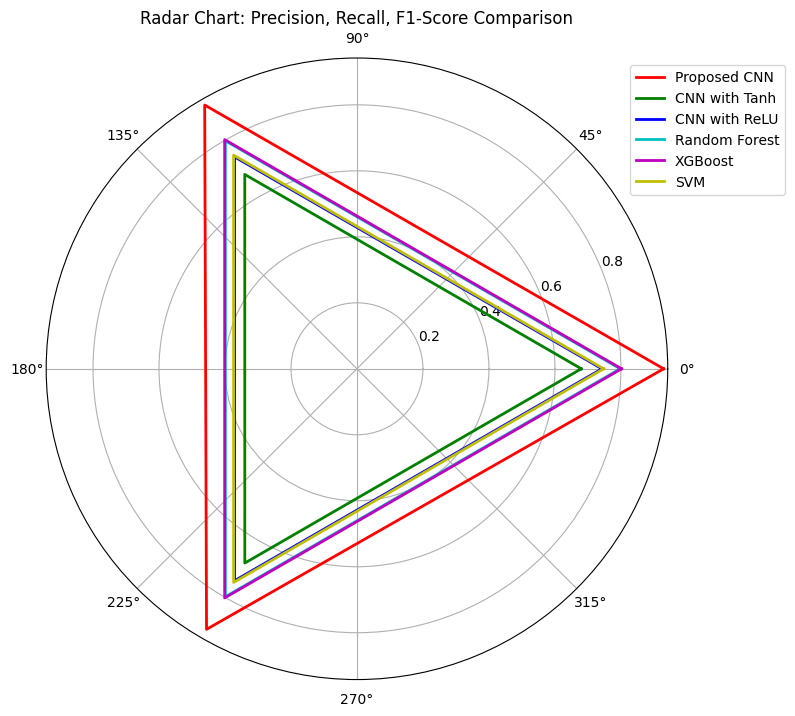

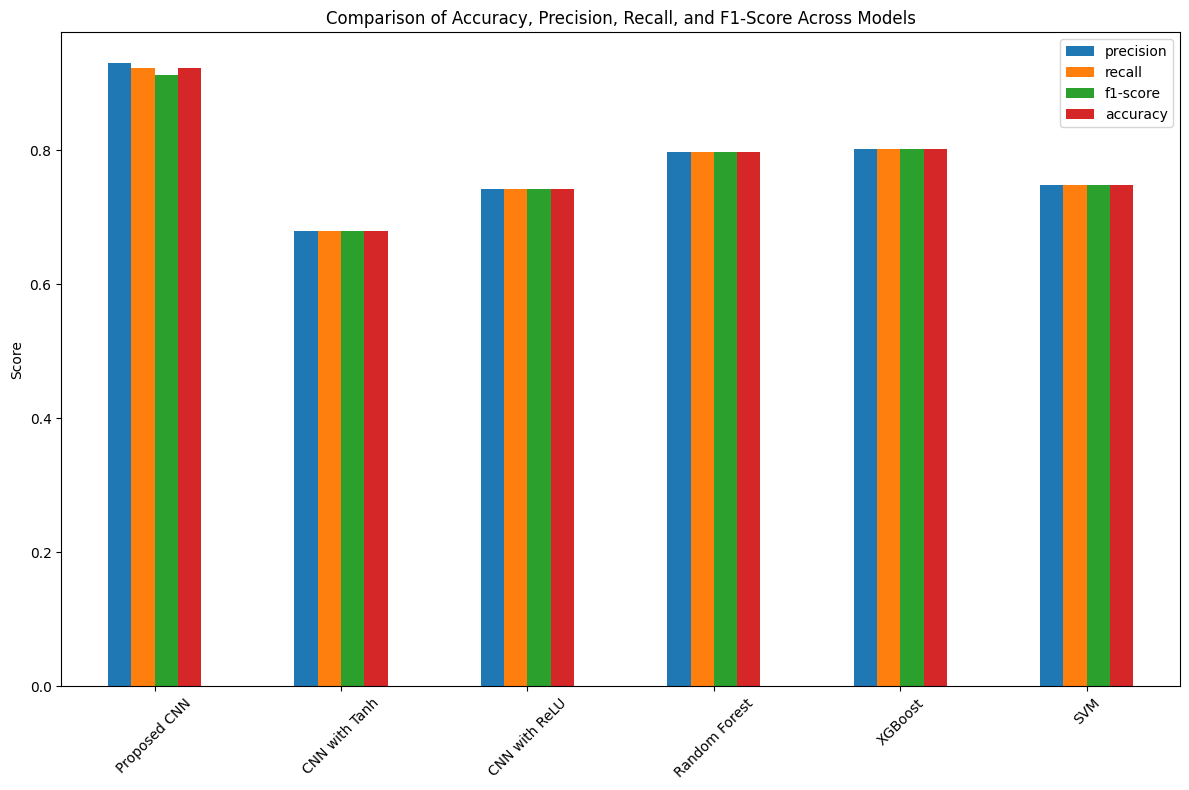

In [ ]:
# Models and their reports
models = ['Proposed CNN', 'CNN with Tanh', 'CNN with ReLU', 'Random Forest', 'XGBoost', 'SVM']
metrics = ['precision', 'recall', 'f1-score', 'accuracy']

# Initialize a DataFrame to store the metrics for each model
model_comparison_df = pd.DataFrame(index=models, columns=metrics)

# Populate the DataFrame with metrics from classification reports
for model, report in zip(models, [ProposedCnnModel_report, CnnWithTanh_report, CnnWithRelu_report, rf_Model_report, xgb_Model_report, svm_Model_report]):
    # Extract weighted average of precision, recall, f1-score
    model_comparison_df.loc[model, 'precision'] = report['weighted avg']['precision']
    model_comparison_df.loc[model, 'recall'] = report['weighted avg']['recall']
    model_comparison_df.loc[model, 'f1-score'] = report['weighted avg']['f1-score']
    model_comparison_df.loc[model, 'accuracy'] = report['accuracy']

# Convert DataFrame to numeric for plotting
model_comparison_df = model_comparison_df.astype(float)

# --- 1. Individual Model Performance: Bar plot of Accuracy and F1-score ---

# Plot bar charts for individual models' accuracy and f1-score
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for Accuracy
ax[0].bar(models, model_comparison_df['accuracy'], color='skyblue')
ax[0].set_title('Accuracy of Individual Models')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Models')

# Bar plot for F1-Score
ax[1].bar(models, model_comparison_df['f1-score'], color='lightcoral')
ax[1].set_title('F1-Score of Individual Models')
ax[1].set_ylabel('F1-Score')
ax[1].set_xlabel('Models')

plt.tight_layout()
plt.show()

# --- 2. Individual Model Performance: Line plot for precision, recall, f1-score, and accuracy ---

plt.figure(figsize=(10, 6))
for metric in metrics:
    plt.plot(models, model_comparison_df[metric], label=metric, marker='o')

plt.title('Line Plot: Performance Comparison of Models')
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend(title='Metrics')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3. Comparative Model Performance: Heatmap for comparison of metrics ---

plt.figure(figsize=(10, 8))
sns.heatmap(model_comparison_df, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Heatmap: Model Comparison of Accuracy, Precision, Recall, F1-Score')
plt.tight_layout()
plt.show()

# --- 4. Comparative Model Performance: Radar chart for comparison ---

def radar_chart(metrics, model_names, colors):
    num_models = len(model_names)
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # To close the loop

    plt.figure(figsize=(8, 8))
    for i, model in enumerate(model_names):
        values = model_comparison_df.loc[model, metrics].tolist()
        values += values[:1]  # Close the loop
        plt.polar(angles, values, label=model, color=colors[i], linewidth=2, linestyle='solid')

    plt.title('Radar Chart: Precision, Recall, F1-Score Comparison')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.tight_layout()
    plt.show()

# Radar chart for precision, recall, and f1-score comparison
radar_chart(metrics[:3], models, colors=['r', 'g', 'b', 'c', 'm', 'y'])

# --- 5. Comparative Model Performance: Bar plot comparison of all metrics ---

model_comparison_df.plot(kind='bar', figsize=(12, 8))
plt.title('Comparison of Accuracy, Precision, Recall, and F1-Score Across Models')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
